In [ ]:
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score
from google.colab import drive
import re
import time
from tqdm import tqdm

# Praprocess Teks

In [ ]:
def clean_text(text):
    # Remove URLs
    text = re.sub(r'http\S+|www\S+', '', text)
    # Remove mentions
    text = re.sub(r'@\w+', '', text)
    # Remove newlines and extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    # apply function hashtag normalizer
    # text = re.sub(r'#\w+', hashtag_normalizer, text()
    # lowercase text
    text = text.lower()
    return text


def text_preprocessing(dataframe, text_column: str, label_column: str):
    print("Text preprocessing is starting...")

    start_time = time.time()  # Start timer

    # Convert the data type of text_column into string
    dataframe[text_column] = dataframe[f"{text_column}"].astype(str)

    dataframe[label_column] = dataframe[f"{label_column}"].astype(int)

    # Apply preprocessing to the specified column with progress bar
    tqdm.pandas(desc="Cleaning text")
    dataframe[f"{text_column}"] = dataframe[f"{text_column}"].progress_apply(clean_text)

    # Remove duplicate values based on 'column_with_text'
    dataframe = df.drop_duplicates(subset=[f"{text_column}"])

    elapsed_time = time.time() - start_time  # Calculate elapsed time
    print(f"Text preprocessing is done in {elapsed_time:.2f} seconds")

    return dataframe

In [ ]:
print("TensorFlow version:", tf.__version__)

# Check if GPU is available
print("GPU available:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.17.0
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
# mounting google drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Replace 'your_dataset.csv' with the path to your dataset
data = pd.read_csv('/content/drive/MyDrive/Tesis/Dataset_BERT.csv')

In [ ]:
data['label'].value_counts()

,count
label,
-1,1000
1,1000
0,1000


In [ ]:
# Extract texts and labels
texts = data['text'].astype(str).tolist()
labels = data['label'].astype(int).tolist()

# Encode labels as integers
le = LabelEncoder()
labels = le.fit_transform(labels)

# Check label distribution
print("Label distribution:", np.bincount(labels))
print("Classes:", le.classes_)

Label distribution: [1000 1000 1000]
Classes: [-1  0  1]


# BERT

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Calculating token lengths: 100%|██████████| 3000/3000 [00:03<00:00, 947.55it/s] 


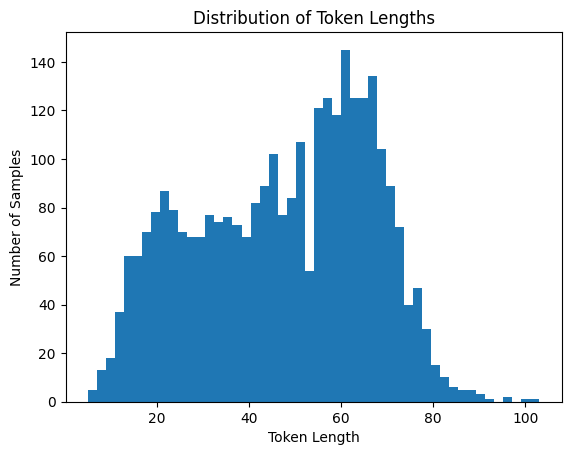

Selected max_length: 74


In [ ]:
from tqdm import tqdm

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Calculate token lengths
token_lens = []

for txt in tqdm(texts, desc="Calculating token lengths"):
    tokens = tokenizer.encode(txt, add_special_tokens=True)
    token_lens.append(len(tokens))

# Plot the distribution
plt.hist(token_lens, bins=50)
plt.xlabel('Token Length')
plt.ylabel('Number of Samples')
plt.title('Distribution of Token Lengths')
plt.show()

# Set max_length to cover 95% of data
max_length = int(np.percentile(token_lens, 95))
print(f"Selected max_length: {max_length}")

In [ ]:
def encode(texts):
    return tokenizer(
        texts,
        add_special_tokens=True,
        max_length=max_length,
        truncation=True,
        padding='max_length',
        return_tensors='tf',
        return_attention_mask=True
    )

encoded_inputs = encode(texts)
input_ids = encoded_inputs['input_ids']
attention_masks = encoded_inputs['attention_mask']

In [ ]:
# Split the data
train_inputs, val_inputs, train_masks, val_masks, train_labels, val_labels = train_test_split(
    input_ids.numpy(), attention_masks.numpy(), labels, test_size=0.2, random_state=42, stratify=labels
)

# Convert inputs and masks to tensors
train_inputs = tf.convert_to_tensor(train_inputs)
val_inputs = tf.convert_to_tensor(val_inputs)
train_masks = tf.convert_to_tensor(train_masks)
val_masks = tf.convert_to_tensor(val_masks)

# Convert labels to tensors
train_labels = tf.convert_to_tensor(train_labels)
val_labels = tf.convert_to_tensor(val_labels)

In [ ]:
BATCH_SIZE = 32

# Training dataset
train_dataset = tf.data.Dataset.from_tensor_slices((
    {'input_ids': train_inputs, 'attention_mask': train_masks},
    train_labels
)).shuffle(len(train_labels)).batch(BATCH_SIZE)

# Validation dataset
val_dataset = tf.data.Dataset.from_tensor_slices((
    {'input_ids': val_inputs, 'attention_mask': val_masks},
    val_labels
)).batch(BATCH_SIZE)

In [ ]:
num_labels = len(le.classes_)  # Should be 3 for your case

model = TFBertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=num_labels
)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5, epsilon=1e-08)

# Loss function
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# Metrics
metrics = ['accuracy']

# Compile the model
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [ ]:
EPOCHS = 10

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS
)

Epoch 1/10
75/75 [==============================] - 84s 546ms/step - loss: 0.7297 - accuracy: 0.7013 - val_loss: 0.3766 - val_accuracy: 0.8717
Epoch 2/10
75/75 [==============================] - 36s 486ms/step - loss: 0.2983 - accuracy: 0.8933 - val_loss: 0.3027 - val_accuracy: 0.8917
Epoch 3/10
75/75 [==============================] - 37s 493ms/step - loss: 0.1438 - accuracy: 0.9508 - val_loss: 0.4197 - val_accuracy: 0.8717
Epoch 4/10
75/75 [==============================] - 37s 500ms/step - loss: 0.0769 - accuracy: 0.9771 - val_loss: 0.3413 - val_accuracy: 0.8967
Epoch 5/10
75/75 [==============================] - 38s 504ms/step - loss: 0.0299 - accuracy: 0.9929 - val_loss: 0.4439 - val_accuracy: 0.8817
Epoch 6/10
75/75 [==============================] - 38s 508ms/step - loss: 0.0452 - accuracy: 0.9829 - val_loss: 0.4327 - val_accuracy: 0.8850
Epoch 7/10
75/75 [==============================] - 40s 537ms/step - loss: 0.0196 - accuracy: 0.9946 - val_loss: 0.4299 - val_accuracy: 0.8950

In [ ]:
# Predict on validation data
val_logits = model.predict(val_dataset)['logits']
val_predictions = np.argmax(val_logits, axis=1)

# Convert tensors to numpy arrays if necessary
val_labels_np = val_labels.numpy()
# Classification report
report = classification_report(val_labels_np, val_predictions, target_names=[str(i) for i in le.classes_])
# Convert le.classes_ elements to strings
print(report)

19/19 [==============================] - 3s 168ms/step
              precision    recall  f1-score   support

          -1       0.82      0.92      0.87       200
           0       0.99      0.88      0.93       200
           1       0.86      0.85      0.86       200

    accuracy                           0.88       600
   macro avg       0.89      0.88      0.88       600
weighted avg       0.89      0.88      0.88       600



19/19 [==============================] - 3s 163ms/step


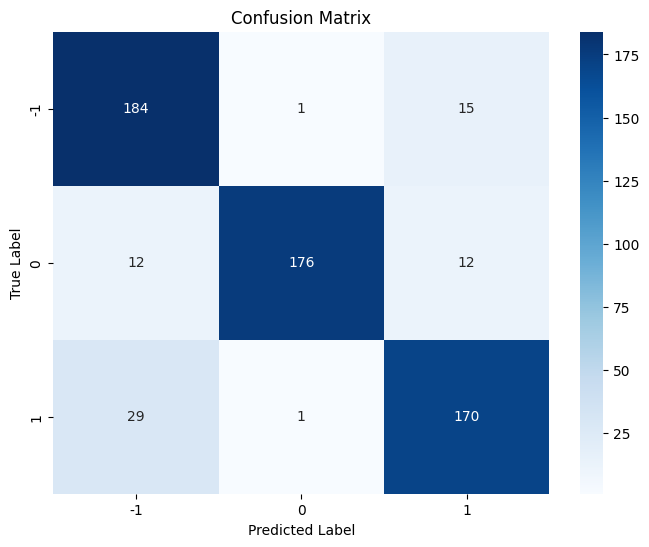

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Step 1: Predict on validation data
val_logits = model.predict(val_dataset)['logits']
val_predictions = np.argmax(val_logits, axis=1)

# Step 2: Generate confusion matrix
val_labels_np = val_labels.numpy()  # Convert tensor to numpy array if necessary
conf_matrix = confusion_matrix(val_labels_np, val_predictions)

# Step 3: Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

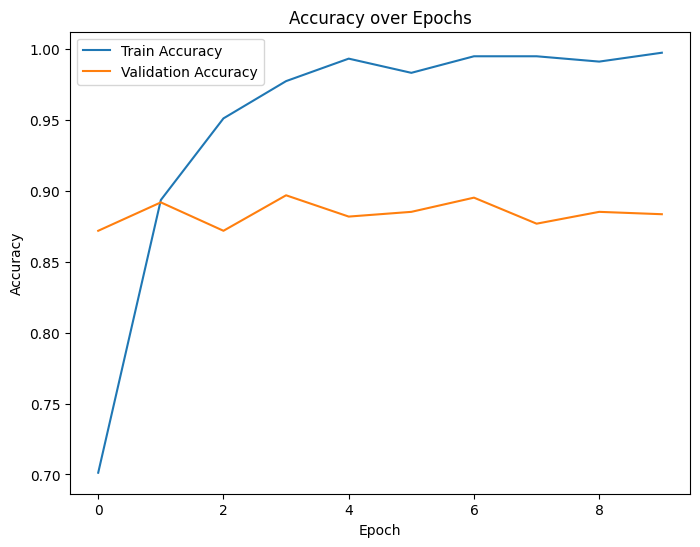

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

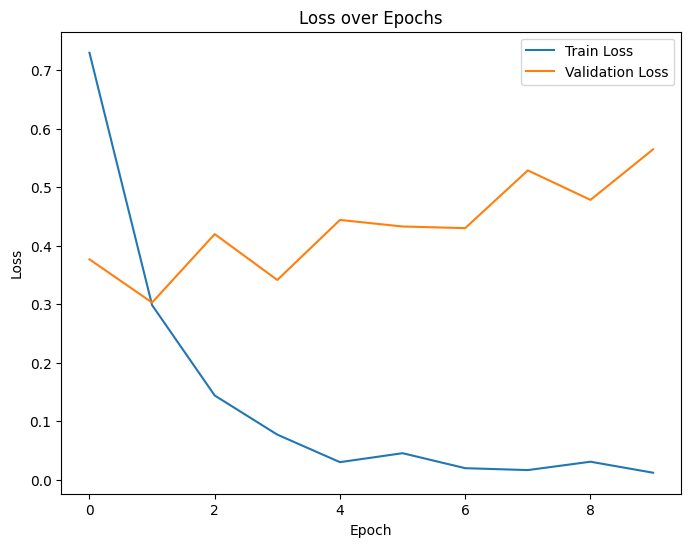

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
model.save_pretrained('fine_tuned_bert_model')
tokenizer.save_pretrained('fine_tuned_bert_model')

('fine_tuned_bert_model/tokenizer_config.json',
 'fine_tuned_bert_model/special_tokens_map.json',
 'fine_tuned_bert_model/vocab.txt',
 'fine_tuned_bert_model/added_tokens.json')

In [ ]:
def predict(text):
    inputs = tokenizer(
        text,
        add_special_tokens=True,
        max_length=max_length,
        truncation=True,
        padding='max_length',
        return_tensors='tf',
        return_attention_mask=True
    )
    outputs = model(inputs)
    logits = outputs.logits
    predicted_class = tf.argmax(logits, axis=1).numpy()
    predicted_label = le.inverse_transform(predicted_class)
    return predicted_label[0]

# Example usage
sample_text = input("masukkan teksmu: ")
predicted_label = predict(sample_text)
print(f"Predicted Label: {predicted_label}")

masukkan teksmu: I have a headache because of thinking about my friend #LongCovid
Predicted Label: 1


# BioBERT

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Calculating token lengths: 100%|██████████| 3000/3000 [00:06<00:00, 472.07it/s]


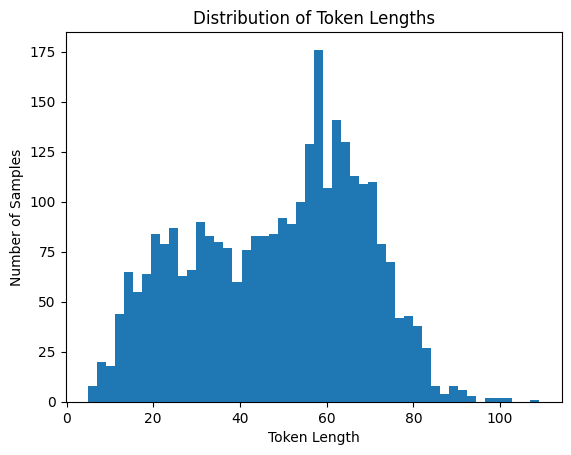

Selected max_length: 77


In [ ]:
from tqdm import tqdm

# Load the BioBERT tokenizer
tokenizer = BertTokenizer.from_pretrained('dmis-lab/biobert-base-cased-v1.1')

# Calculate token lengths
token_lens = []

for txt in tqdm(texts, desc="Calculating token lengths"):
    tokens = tokenizer.encode(txt, add_special_tokens=True)
    token_lens.append(len(tokens))

# Plot the distribution
plt.hist(token_lens, bins=50)
plt.xlabel('Token Length')
plt.ylabel('Number of Samples')
plt.title('Distribution of Token Lengths')
plt.show()

# Set max_length to cover 95% of data
max_length = int(np.percentile(token_lens, 95))
print(f"Selected max_length: {max_length}")

In [ ]:
def encode(texts):
    return tokenizer(
        texts,
        add_special_tokens=True,
        max_length=max_length,
        truncation=True,
        padding='max_length',
        return_tensors='tf',
        return_attention_mask=True
    )

encoded_inputs = encode(texts)
input_ids = encoded_inputs['input_ids']
attention_masks = encoded_inputs['attention_mask']

In [ ]:
# Split the data
train_inputs, val_inputs, train_masks, val_masks, train_labels, val_labels = train_test_split(
    input_ids.numpy(), attention_masks.numpy(), labels, test_size=0.2, random_state=42, stratify=labels
)

# Convert inputs and masks to tensors
train_inputs = tf.convert_to_tensor(train_inputs)
val_inputs = tf.convert_to_tensor(val_inputs)
train_masks = tf.convert_to_tensor(train_masks)
val_masks = tf.convert_to_tensor(val_masks)

# Convert labels to tensors
train_labels = tf.convert_to_tensor(train_labels)
val_labels = tf.convert_to_tensor(val_labels)

In [ ]:
BATCH_SIZE = 32

# Training dataset
train_dataset = tf.data.Dataset.from_tensor_slices((
    {'input_ids': train_inputs, 'attention_mask': train_masks},
    train_labels
)).shuffle(len(train_labels)).batch(BATCH_SIZE)

# Validation dataset
val_dataset = tf.data.Dataset.from_tensor_slices((
    {'input_ids': val_inputs, 'attention_mask': val_masks},
    val_labels
)).batch(BATCH_SIZE)

In [ ]:
num_labels = len(le.classes_)  # Should be 3 for your case

model = TFBertForSequenceClassification.from_pretrained(
    'dmis-lab/biobert-base-cased-v1.1',
    num_labels=num_labels,
    from_pt=True
)

pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5, epsilon=1e-08)

# Loss function
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# Metrics
metrics = ['accuracy']

# Compile the model
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [ ]:
EPOCHS = 10

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS
)

Epoch 1/10
75/75 [==============================] - 93s 628ms/step - loss: 0.8211 - accuracy: 0.6346 - val_loss: 0.5134 - val_accuracy: 0.7967
Epoch 2/10
75/75 [==============================] - 40s 536ms/step - loss: 0.3762 - accuracy: 0.8562 - val_loss: 0.3503 - val_accuracy: 0.8617
Epoch 3/10
75/75 [==============================] - 40s 532ms/step - loss: 0.2352 - accuracy: 0.9133 - val_loss: 0.4166 - val_accuracy: 0.8417
Epoch 4/10
75/75 [==============================] - 40s 530ms/step - loss: 0.1511 - accuracy: 0.9483 - val_loss: 0.4263 - val_accuracy: 0.8450
Epoch 5/10
75/75 [==============================] - 40s 529ms/step - loss: 0.0619 - accuracy: 0.9808 - val_loss: 0.4393 - val_accuracy: 0.8467
Epoch 6/10
75/75 [==============================] - 40s 536ms/step - loss: 0.0474 - accuracy: 0.9854 - val_loss: 0.4939 - val_accuracy: 0.8600
Epoch 7/10
75/75 [==============================] - 40s 531ms/step - loss: 0.0239 - accuracy: 0.9925 - val_loss: 0.5465 - val_accuracy: 0.8550

In [ ]:
# Predict on validation data
val_logits = model.predict(val_dataset)['logits']
val_predictions = np.argmax(val_logits, axis=1)

# Convert tensors to numpy arrays if necessary
val_labels_np = val_labels.numpy()
# Classification report
report = classification_report(val_labels_np, val_predictions, target_names=[str(i) for i in le.classes_])
# Convert le.classes_ elements to strings
print(report)

19/19 [==============================] - 6s 166ms/step
              precision    recall  f1-score   support

          -1       0.87      0.79      0.83       200
           0       0.96      0.95      0.95       200
           1       0.78      0.87      0.82       200

    accuracy                           0.87       600
   macro avg       0.87      0.87      0.87       600
weighted avg       0.87      0.87      0.87       600



19/19 [==============================] - 3s 170ms/step


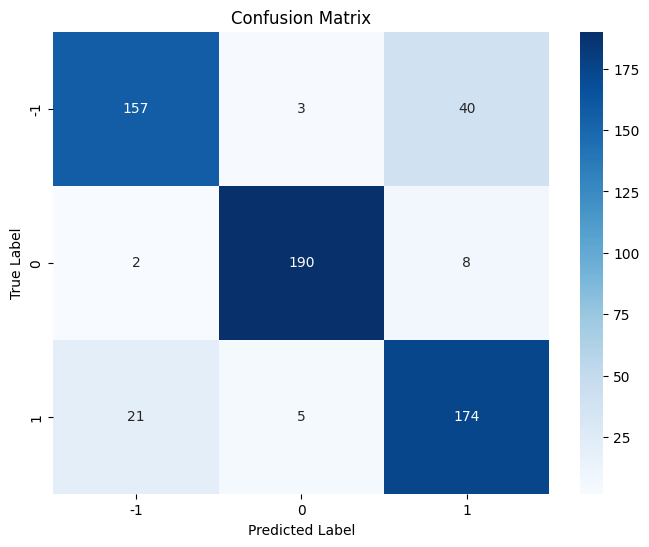

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Step 1: Predict on validation data
val_logits = model.predict(val_dataset)['logits']
val_predictions = np.argmax(val_logits, axis=1)

# Step 2: Generate confusion matrix
val_labels_np = val_labels.numpy()  # Convert tensor to numpy array if necessary
conf_matrix = confusion_matrix(val_labels_np, val_predictions)

# Step 3: Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

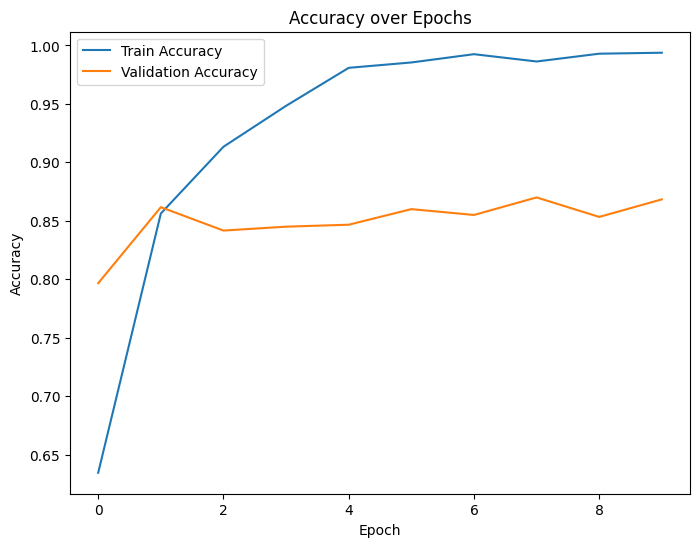

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

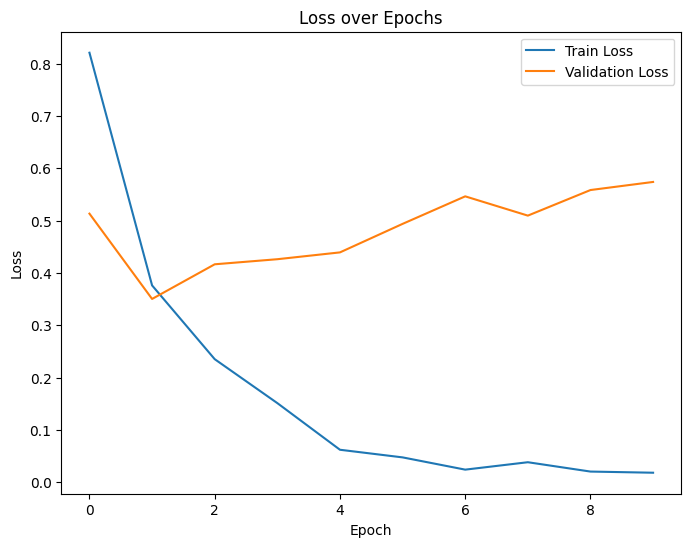

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
model.save_pretrained('/content/drive/MyDrive/Tesis/fine_tuned_biobert_model')
tokenizer.save_pretrained('/content/drive/MyDrive/Tesis/fine_tuned_biobert_model')

('/content/drive/MyDrive/Tesis/fine_tuned_biobert_model/tokenizer_config.json',
 '/content/drive/MyDrive/Tesis/fine_tuned_biobert_model/special_tokens_map.json',
 '/content/drive/MyDrive/Tesis/fine_tuned_biobert_model/vocab.txt',
 '/content/drive/MyDrive/Tesis/fine_tuned_biobert_model/added_tokens.json')

In [ ]:
def predict(text):
    inputs = tokenizer(
        text,
        add_special_tokens=True,
        max_length=max_length,
        truncation=True,
        padding='max_length',
        return_tensors='tf',
        return_attention_mask=True
    )
    outputs = model(inputs)
    logits = outputs.logits
    predicted_class = tf.argmax(logits, axis=1).numpy()
    predicted_label = le.inverse_transform(predicted_class)
    return predicted_label[0]

# Example usage
sample_text = input("masukkan teksmu: ")
predicted_label = predict(sample_text)
print(f"Predicted Label: {predicted_label}")

masukkan teksmu: i have a headache because of thinking about my friend #longcovid
Predicted Label: -1
